# Predictive maintenance

## 1. Introdução

A Manutenção Preditiva (PdM) é uma ótima aplicação da Análise de Sobrevivência, pois consiste em prever quando ocorrerá a falha de um equipamento e, portanto, alertar a equipe de manutenção para evitar essa falha. De fato, modelar com precisão se e quando uma máquina quebrará é crucial para empresas industriais e de manufatura, pois pode ajudar:

- Manter um ambiente de trabalho seguro, garantindo que as máquinas estejam funcionando corretamente

- Aumentar a produtividade evitando a manutenção reativa não planejada e minimizando o tempo de inatividade

- Otimizar custos eliminando a necessidade de muitas verificações ou reparos desnecessários de componentes - também conhecido como manutenção preventiva

![](https://cdn.pixabay.com/photo/2016/11/27/21/42/stock-1863880_960_720.jpg)

Nos últimos dois anos, graças ao uso de tecnologias da Internet das Coisas (IoT), uma infinidade de dados foi gerada por vários sensores em máquinas, componentes mecânicos e elétricos, como temperatura, vibração, tensão ou pressão. Esse tipo de informação pode ser usado para prever falhas futuras.

## 2 - Contexto

Consideraremos que uma empresa de manufatura utiliza muitas máquinas para construir seus produtos finais. A fábrica está usando tecnologias de IoT por meio de sensores inteligentes para medir e salvar vários tipos de entradas do ambiente físico e o estado de seus equipamentos.

Infelizmente, toda vez que uma máquina quebra, a produção é interrompida, o que custa à empresa milhares de dólares em reparos e taxas de entrega atrasada.

## 3 - Conjunto de dados

### 3.1 - Descrição e visão geral

O conjunto de dados que a equipe deseja usar contém as seguintes variáveis:

**lifetime:** Número de semanas que a máquina esteve ativa

**broken:** Especifica se a máquina foi quebrada ou ainda não foi quebrada nas semanas correspondentes em atividade

**pressureInd:** O índice de pressão é usado para quantificar o fluxo de líquido através de tubos, pois uma queda repentina de pressão pode indicar um vazamento

**moistureInd:** O índice de umidade é uma medida da umidade relativa do ar. É importante acompanhá-lo, pois a umidade excessiva pode criar mofo e danificar o equipamento
  
**temperatureInd:** O índice de temperatura da máquina é calculado usando dispositivos de tensão chamados thermocouples que traduzem uma mudança na tensão em medida de temperatura. É registrado para evitar danos aos circuitos elétricos, incêndio ou até explosão

**team:**  Este indicador especifica qual equipe está usando a máquina

**provider:** Este indicador especifica o nome do fabricante da máquina

In [1]:
# Importing modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset

# Reading the dataset
raw_dataset = Dataset('maintenance').load()
print("The raw_dataset has the following shape: {}.".format(raw_dataset.shape))
raw_dataset.head()

The raw_dataset has the following shape: (1000, 7).


,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1


In [2]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lifetime        1000 non-null   int64  
 1   broken          1000 non-null   int64  
 2   pressureInd     1000 non-null   float64
 3   moistureInd     1000 non-null   float64
 4   temperatureInd  1000 non-null   float64
 5   team            1000 non-null   object 
 6   provider        1000 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 54.8+ KB


## 4 - Análise Exploratória de Dados

Vamos realizar uma análise exploratória de dados (EDA) para entender como são os dados e começar a responder perguntas interessantes sobre nosso problema.

Existem 3 variáveis numéricas (`pressureInd`, `moistureInd`, `temperatureInd`) e 2 variáveis categóricas (`team`, `provider`). Vamos codificar as variáveis categóricas como vetores one-hot e definir os recursos de modelagem:

In [3]:
# Defining the time and event column
time_column = 'lifetime'
event_column = 'broken'

# Encoding the categorical variables as one-hot vectors
categories = ['provider', 'team']
dataset = pd.get_dummies(raw_dataset, columns = categories, drop_first=True)

# Defining the modeling features
features = np.setdiff1d(dataset.columns, ['lifetime', 'broken']).tolist()

### 4.1 - Valores nulos e duplicados

A primeira coisa a fazer é verificar se o conjunto de dados contém valores nulos e se possui linhas duplicadas.

In [4]:
# Checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The dataset contains {} null values".format(N_null)) #0 null values

# Removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The dataset contains {} duplicates".format(N_dupli))

# Number of samples in the dataset
N = dataset.shape[0]

The dataset contains 0 null values
The dataset contains 0 duplicates


### 4.2 - Exploração visual e estatísticas

Vamos conferir/visualizar as estatísticas das features:

#### 4.2.1 - Variáveis numéricas

Vamos exibir o boxplot e o histograma de cada recurso

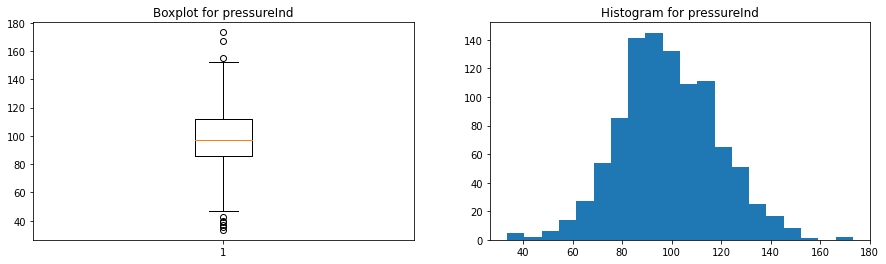

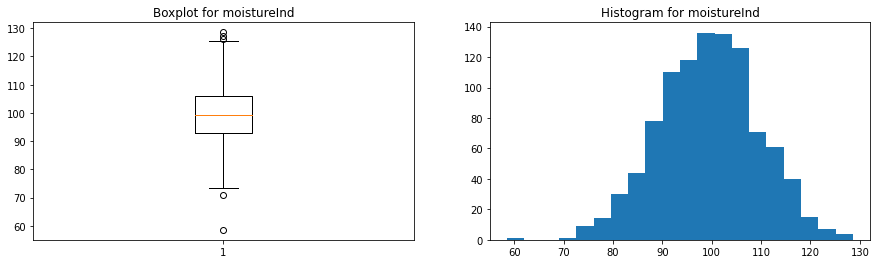

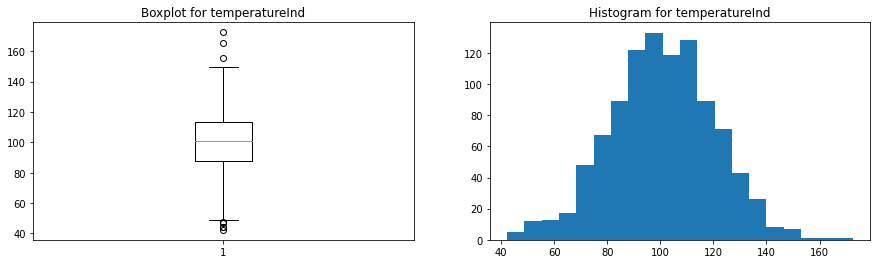

In [5]:
for feature in ['pressureInd','moistureInd','temperatureInd']:

    # Creating an empty chart
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

    # Extracting the feature values
    x = raw_dataset[feature].values

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title( 'Boxplot for {}'.format(feature) )

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title( 'Histogram for {}'.format(feature) )

    # Display
    plt.show()

Essas features têm muito poucos outliers (aqui, não há necessidade real de removê-los) e parecem seguir distribuições normais.

#### 4.2.2 - Variáveis categóricas

Vamos exibir as ocorrências das categorias em um gráfico de barras para cada feature

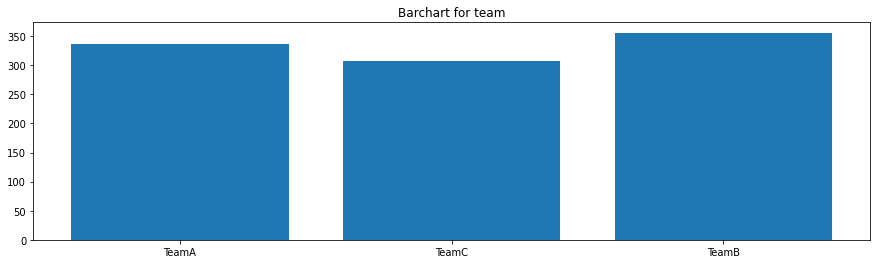

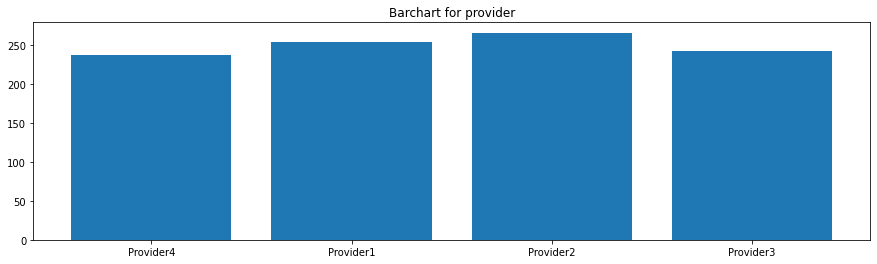

In [6]:
from collections import Counter
for feature in ['team','provider']:

    # Creating an empty chart
    fig, ax = plt.subplots(figsize=(15, 4))

    # Extracting the feature values
    x = raw_dataset[feature].values

    # Counting the number of occurrences for each category
    data = Counter(x)
    category = list(data.keys())
    counts = list(data.values())

    # Boxplot
    ax.bar(category, counts)

    # Display
    plt.title( 'Barchart for {}'.format(feature) )
    plt.show()


4.2.3 - Tempo & Evento

Mostraremos as ocorrências de evento e censura, bem como a distribuição da variável de saída tempo para ambas as situações.

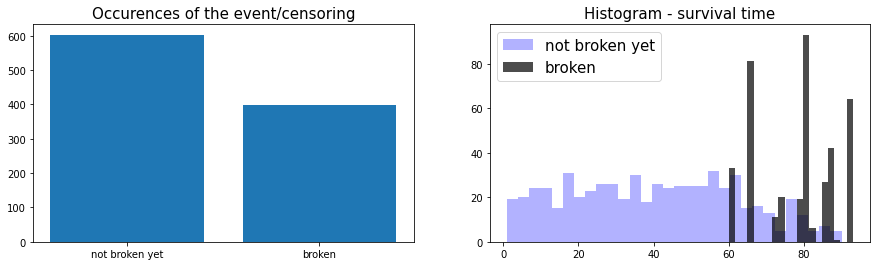

In [7]:
# Creating an empty chart
fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(15, 4))

# Counting the number of occurrences for each category 
data = Counter(raw_dataset['broken'].replace({0:'not broken yet', 1:'broken'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Displaying the occurrences of the event/censoring
ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title( 'Occurences of the event/censoring', fontsize=15)

# Showing the histogram of the survival times for the censoring
time_0 = raw_dataset.loc[ raw_dataset['broken'] == 0, 'lifetime']
ax2.hist(time_0, bins=30, alpha=0.3, color='blue', label = 'not broken yet')

# Showing the histogram of the survival times for the events
time_1 = raw_dataset.loc[ raw_dataset['broken'] == 1, 'lifetime']
ax2.hist(time_1, bins=20, alpha=0.7, color='black', label = 'broken')
ax2.set_title( 'Histogram - survival time', fontsize=15)

# Displaying everything side-by-side
plt.legend(fontsize=15)
plt.show()

Aqui, podemos ver que 2/3 dos dados são censurados e que as falhas começam a acontecer quando a máquina está ativa há pelo menos 60 semanas.

### 4.3 - Correlações

Vamos calcular e visualizar a correlação entre as variáveis

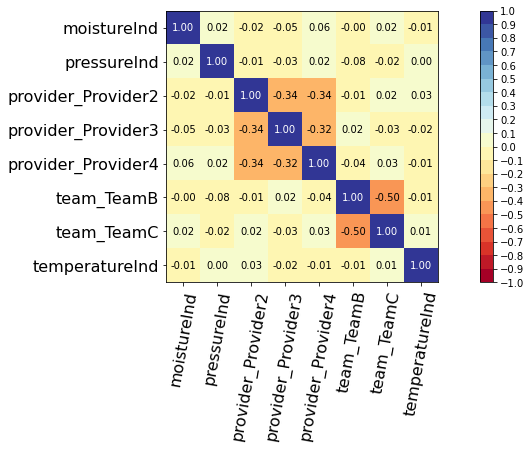

In [8]:
from pysurvival.utils.display import correlation_matrix
correlation_matrix(dataset[features], figure_size=(15, 5))

Como podemos ver, não há correlações alarmantes.

## 5 - Modelagem

Para realizar a validação cruzada posteriormente e avaliar o desempenho do modelo, vamos dividir o conjunto de dados em conjuntos de treinamento e teste.

In [9]:
# Building training and testing sets
from sklearn.model_selection import train_test_split
index_train, index_test = train_test_split(range(N), test_size=0.4, random_state=42)
data_train = dataset.loc[index_train].reset_index(drop=True )
data_test  = dataset.loc[index_test].reset_index(drop=True)

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

Agora, vamos ajustar um modelo *Linear MTLR* ao conjunto de treinamento.

In [10]:
from pysurvival.models.multi_task import LinearMultiTaskModel

# Initializing the MTLR with a time axis split into 300 intervals
linear_mtlr = LinearMultiTaskModel(bins=300)

# Fitting the model
linear_mtlr.fit(X_train, T_train, E_train, num_epochs = 1000,
                init_method = 'orthogonal', optimizer ='rmsprop',
                lr = 1e-3, l2_reg = 3,  l2_smooth = 3, )

% Completion: 100%|***********************************************|Loss: 276.31


LinearMultiTaskModel

Podemos dar uma olhada nos valores da função de perda:

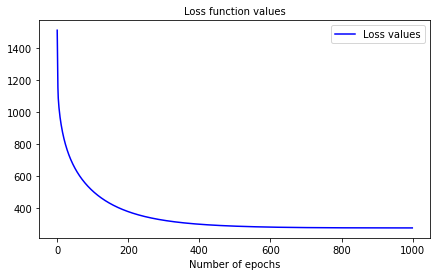

In [11]:
from pysurvival.utils.display import display_loss_values
display_loss_values(linear_mtlr, figure_size=(7, 4))

## 6 - Validação Cruzada

Para avaliar o desempenho do modelo, dividimos anteriormente o conjunto de dados original em conjuntos de treinamento e teste, para que agora possamos calcular suas métricas de desempenho no conjunto de teste:

### 6.1 - C-index

O índice C representa a avaliação global do poder de discriminação do modelo: esta é a capacidade do modelo de fornecer corretamente uma classificação confiável dos tempos de sobrevivência com base nas pontuações de risco individuais. Em geral, quando o índice C está próximo de 1, o modelo tem um poder discriminatório quase perfeito; mas se for próximo de 0,5, não tem capacidade de discriminar entre indivíduos de baixo e alto risco.


In [12]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(linear_mtlr, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.92


### 6.2 - Brier Score

A pontuação de Brier mede as discrepâncias médias entre o status e as probabilidades estimadas em um determinado momento. Assim, quanto menor a pontuação (geralmente abaixo de 0,25), melhor o desempenho preditivo. Para avaliar a medida de erro geral em vários pontos de tempo, o Integrated Brier Score (IBS) geralmente também é calculado.

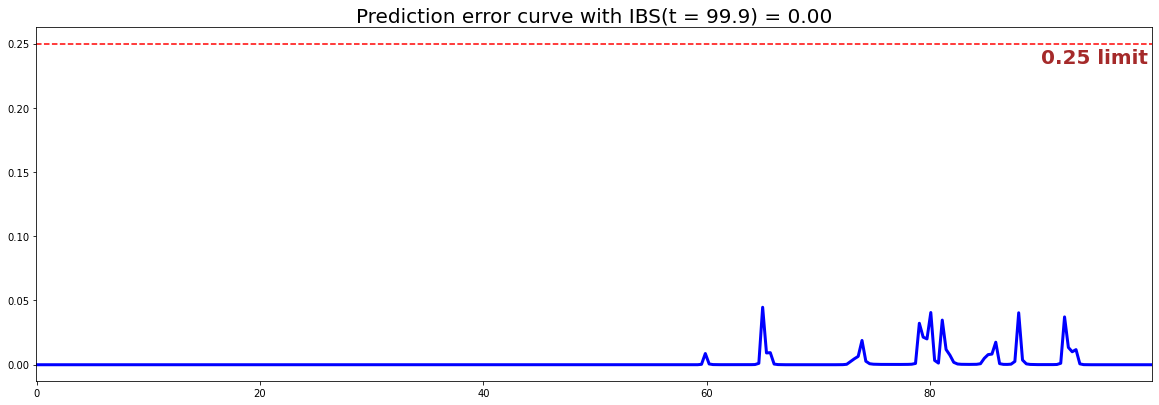

0.001567530146296676

In [13]:
from pysurvival.utils.display import integrated_brier_score
integrated_brier_score(linear_mtlr, X_test, T_test, E_test, t_max=100,
                       figure_size=(20, 6.5))

O IBS está muito próximo de 0 em todo o eixo de tempo do modelo. Isso indica que o modelo terá habilidades preditivas muito boas.

## 7 - Previsões

### 7.1 - Previsões gerais

Agora que construímos um modelo que parece fornecer ótimos desempenhos, vamos comparar a série temporal do número real e previsto de máquinas com falha, para cada tempo $t$.

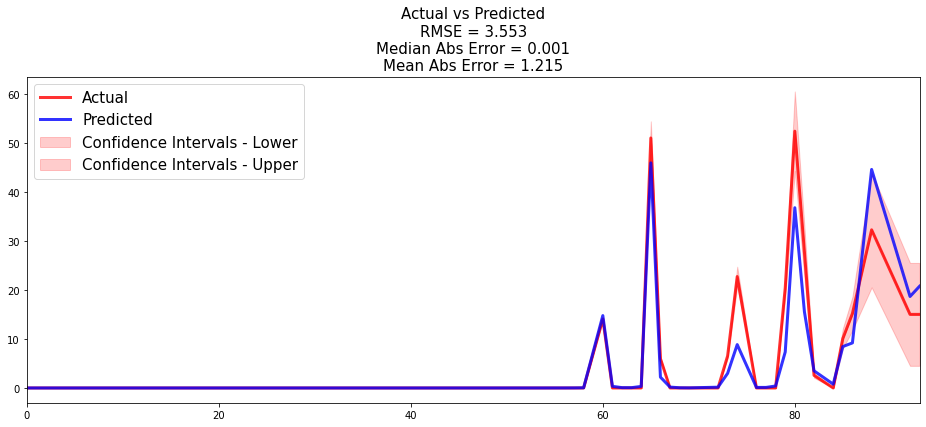

In [14]:
from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(linear_mtlr, X_test, T_test, E_test,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])

Com base nas métricas de desempenho, esperava-se que a série temporal fosse muito próxima; aqui, o modelo apresenta um erro médio de ~ 1.2 máquina em toda a linha do tempo.

7.2 - Previsões individuais

Agora que sabemos que podemos fornecer previsões confiáveis para um grupo inteiro. Vamos calcular as previsões de sobrevivência no nível individual.

Primeiro, podemos construir os grupos de risco com base na distribuição dos escores de risco. A função auxiliar `create_risk_groups`, que pode ser encontrada em `pysurvival.utils`, nos ajudará a fazer isso:

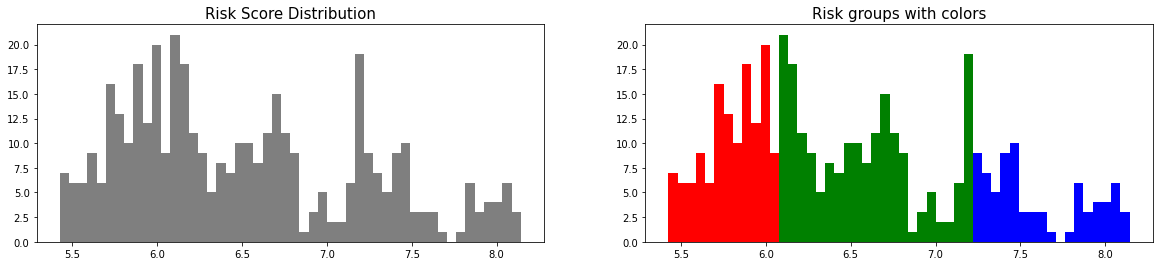

In [15]:
from pysurvival.utils.display import create_risk_groups

risk_groups = create_risk_groups(model=linear_mtlr, X=X_test,
    use_log = True, num_bins=50, figure_size=(20, 4),
    low= {'lower_bound':0, 'upper_bound':6.05, 'color':'red'},
    medium= {'lower_bound': 6.05, 'upper_bound':7.2, 'color':'green'},
    high= {'lower_bound':7.2, 'upper_bound':9.0, 'color':'blue'}
    )

Aqui, podemos ver que 3 grupos principais, grupos de baixo, médio e alto risco, podem ser criados. Como o índice C é alto, o modelo será capaz de classificar perfeitamente os tempos de sobrevivência de uma unidade aleatória de cada grupo, de modo que $t_{high} \leq t_{medium}\leq t_{low}$

Vamos selecionar aleatoriamente unidades individuais em cada grupo e comparar as funções de sobrevivência. Para demonstrar nosso ponto, selecionaremos propositadamente unidades que vivenciaram um evento para visualizar o tempo real do evento.

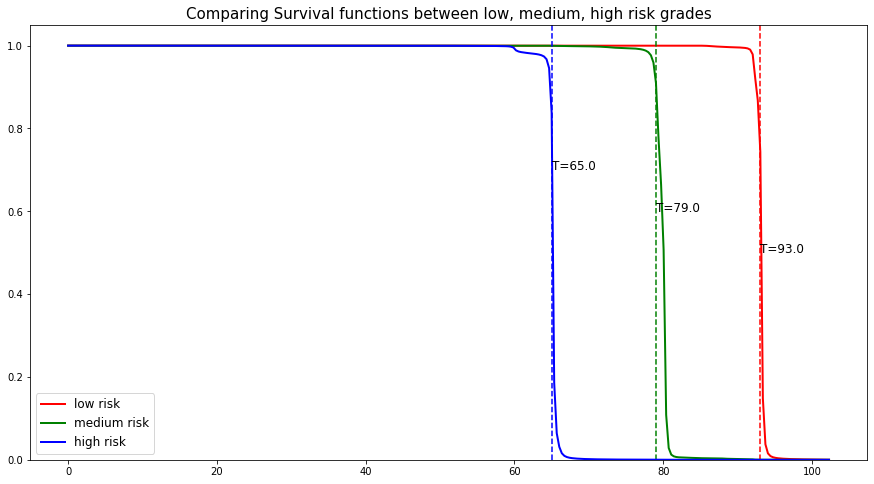

In [16]:
# Initializing the figure
fig, ax = plt.subplots(figsize=(15, 8))

# Selecting a random individual that experienced failure from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()) :

    # Selecting the individuals that belong to this group
    if len(indexes) == 0 :
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]

    # Randomly extracting a machine that experienced failure from each group
    choices = np.argwhere((E==1.)).flatten()
    if len(choices) == 0 :
        continue
    k = np.random.choice( choices, 1)[0]

    # Saving the time of event
    t = T[k]

    # Computing the Survival function for all times t
    survival = linear_mtlr.predict_survival(X[k, :]).flatten()

    # Displaying the functions
    label_ = '{} risk'.format(label)
    plt.plot(linear_mtlr.times, survival, color = color, label=label_, lw=2)
    groups.append(label)

    # Actual time
    plt.axvline(x=t, color=color, ls ='--')
    ax.annotate('T={:.1f}'.format(t), xy=(t, 0.5*(1.+0.2*i)),
        xytext=(t, 0.5*(1.+0.2*i)), fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = "Comparing Survival functions between {} risk grades".format(groups_str)
plt.legend(fontsize=12)
plt.title(title, fontsize=15)
plt.ylim(0, 1.05)
plt.show()

Como podemos ver, o modelo consegue prever perfeitamente o tempo do evento, aqui corresponde a uma queda repentina na função de sobrevivência individual.

## 8 - Conclusão

Agora podemos salvar nosso modelo para colocá-lo em produção e pontuar máquinas futuras.

In [17]:
# Let's now save our model
# from pysurvival.utils import save_model
# save_model(linear_mtlr, '/Users/xxx/Desktop/pdm_linear_mtlr.zip')

Neste exemplo, mostramos que é possível prever com grande grau de certeza quando uma máquina irá falhar. A equipe de Data Science poderia prever a função de sobrevivência das máquinas todos os dias, para que 1 ou 2 semanas antes da máquina falhar, o gerente da fábrica seja notificado para que as ações necessárias possam ser tomadas.